## Mercari Price Suggestion Challenge

Mercari is an online marketplace similar to eBay or Amazon. People can list products to sell. 

Mercari would like us to develope an algorithm which automatically suggests a product's price based on the product's description and other information. 

A product's description and other information are mostly text data. 

## Loading Libraries

In [18]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

## EDA

In [25]:
train = pd.read_csv('train.tsv', sep = '\t')

In [26]:
#Sampling only 10% of the data because of time constraints 
reduced_X_train = train.sample(frac=0.1).reset_index(drop=True)

In [27]:
reduced_X_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,831618,Viktor and Rolf Flowerbomb,1,Beauty/Fragrance/Women,Sephora,22.0,0,"New, never been used Viktor and Rolf Flowerbom..."
1,118899,MacBook Air 2015 hold,2,Electronics/Computers & Tablets/Laptops & Netb...,Apple,809.0,0,New open box. Comes with case and keyboard pro...
2,1107380,Santa figurine Lenox,3,Home/Seasonal Décor/Christmas,NaN,18.0,1,No description yet
3,746953,Michael kors cross body jet set,3,Women/Women's Handbags/Messenger & Crossbody,Michael Kors,66.0,0,Michael kors cross body jet set bag
4,202860,❤ Bath & Body works body mist,1,Beauty/Fragrance/Women,Bath & Body Works,16.0,0,Bundle includes: Forever Red 90% full /orig. [...


In [28]:
reduced_X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148254 entries, 0 to 148253
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   train_id           148254 non-null  int64  
 1   name               148254 non-null  object 
 2   item_condition_id  148254 non-null  int64  
 3   category_name      147642 non-null  object 
 4   brand_name         84599 non-null   object 
 5   price              148254 non-null  float64
 6   shipping           148254 non-null  int64  
 7   item_description   148254 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 9.0+ MB


In [29]:
reduced_X_train.astype('O').describe().T

,count,unique,top,freq
train_id,148254,148254,524288,1
name,148254,137697,Bundle,253
item_condition_id,148254,5,1,64484
category_name,147642,1024,"Women/Athletic Apparel/Pants, Tights, Leggings",5991
brand_name,84599,2332,PINK,5368
price,148254.0,469.0,10.0,10041.0
shipping,148254,2,0,81662
item_description,148254,133819,No description yet,8133


## Examine the Target Value (Price)

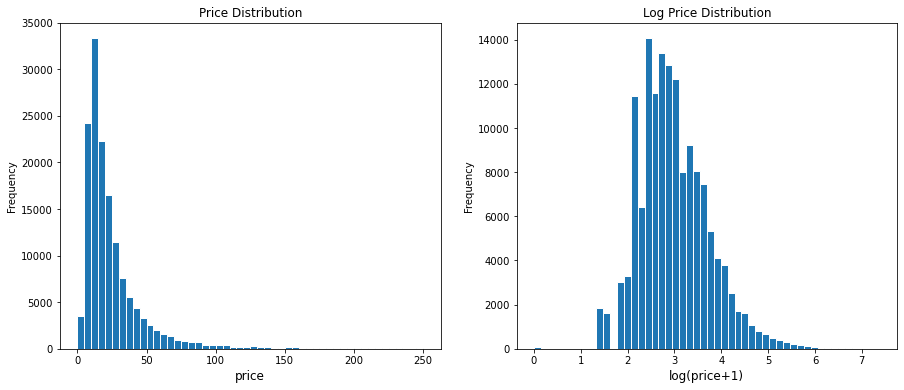

In [31]:
# Plot Price Distribution
plt.subplot(1, 2, 1)
(reduced_X_train['price']).plot.hist(bins=50, figsize=(15, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

#Plot Log Price Distribution
plt.subplot(1, 2, 2)
np.log(reduced_X_train['price']+1).plot.hist(bins=50, figsize=(15,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Log Price Distribution', fontsize=12)

plt.show()

Log-Transform the right-skewed target so that it's more normally distributed, which will work better with modelling and Central Limit Theorem

In [32]:
reduced_y_train = np.log1p(reduced_X_train['price'])

In [36]:
#dropping the target from the reduced_X_train dataframe
reduced_X_train = reduced_X_train.drop('price', axis = 1)

## Data Imputation/Cleaning

In [37]:
reduced_X_train['category_name'] = reduced_X_train['category_name'].fillna('Other').astype(str)
reduced_X_train['brand_name'] = reduced_X_train['brand_name'].fillna('missing').astype(str)
reduced_X_train['shipping'] = reduced_X_train['shipping'].astype(str)
reduced_X_train['item_condition_id'] = reduced_X_train['item_condition_id'].astype(str)
reduced_X_train['item_description'] = reduced_X_train['item_description'].fillna('None')

## Topic Modeling using LDA – Latent Dirichlet Allocation

In [39]:
from sklearn.decomposition import LatentDirichletAllocation

# Initialize CountVectorizer
cvectorizer = CountVectorizer(max_features=20000,
                              stop_words='english', 
                              lowercase=True)

# Fit it to our dataset
cvz = cvectorizer.fit_transform(reduced_X_train['item_description'])

# Initialize LDA Model with 10 Topics
lda_model = LatentDirichletAllocation(n_components=10,
                                      random_state=42)

# Fit it to our CountVectorizer Transformation
X_topics = lda_model.fit_transform(cvz)

# Define variables
n_top_words = 10
topic_summaries = []

# Get the topic words
topic_word = lda_model.components_
# Get the vocabulary from the text features
vocab = cvectorizer.get_feature_names()

# Display the Topic Models
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

Topic 0: rm | shipping | inches | note | pink | stickers | available | necklace | free | listing
Topic 1: free | shipping | bundle | price | rm | items | new | firm | ship | save
Topic 2: size | small | black | blue | white | shirt | medium | nike | large | bra
Topic 3: new | brand | box | tags | rm | price | used | authentic | size | original
Topic 4: used | new | color | makeup | brush | matte | lip | palette | brand | authentic
Topic 5: size | worn | condition | black | cute | small | new | pink | super | fit
Topic 6: condition | used | good | great | bag | wear | leather | size | inside | excellent
Topic 7: game | gold | ring | watch | games | steel | stainless | band | 10 | works
Topic 8: oz | skin | body | new | used | oil | fl | bottle | bath | rm
Topic 9: description | iphone | case | phone | plus | 6s | screen | charger | hair | ipad


## Feature Pre-Processing

In [41]:
from sklearn.pipeline import FeatureUnion

default_preprocessor = CountVectorizer().build_preprocessor()

def build_preprocessor(field):
    field_idx = list(reduced_X_train.columns).index(field)
    return lambda x: default_preprocessor(x[field_idx])

vectorizer = FeatureUnion([
    ('name', CountVectorizer(
        ngram_range=(1, 2),
        max_features=50000,
        preprocessor=build_preprocessor('name'))),
    ('category_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('category_name'))),
    ('brand_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('brand_name'))),
    ('shipping', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('shipping'))),
    ('item_condition_id', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('item_condition_id'))),
    ('item_description', TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=55000,
        stop_words='english',
        preprocessor=build_preprocessor('item_description'))),
])

In [43]:
# Create Transformed Train Set
reduced_Xt_train = vectorizer.fit_transform(reduced_X_train.values)
reduced_Xt_train

<148254x108365 sparse matrix of type '<class 'numpy.float64'>'
	with 4661206 stored elements in Compressed Sparse Row format>

## Modeling

Ridge Regression

LASSO Regression

Light GBM

## Define RMSLE Function

In [44]:
def get_rmsle(y, pred): return np.sqrt(mean_squared_error(y, pred))

We're evaluating the models with the RMSLE metrics because the Target has been log-transformed

## Ridge Cross Validation

In [50]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Create 3-Fold CV
cv = KFold(n_splits=3, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(reduced_Xt_train):
    # Define Ridge Model
    model_ridge = Ridge(fit_intercept=True, random_state=42)
    
    # Fit Ridge Model
    model_ridge.fit(reduced_Xt_train[train_ids], reduced_y_train[train_ids])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_ridge.predict(reduced_Xt_train[train_ids])
    rmsle_train = get_rmsle(y_pred_train, reduced_y_train[train_ids])
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_ridge.predict(reduced_Xt_train[valid_ids])
    rmsle_valid = get_rmsle(y_pred_valid, reduced_y_train[valid_ids])
    
    print(f'Ridge Training RMSLE: {rmsle_train:.5f}')
    print(f'Ridge Validation RMSLE: {rmsle_valid:.5f}')

Ridge Training RMSLE: 0.29547
Ridge Validation RMSLE: 0.52397
Ridge Training RMSLE: 0.29511
Ridge Validation RMSLE: 0.52510
Ridge Training RMSLE: 0.29672
Ridge Validation RMSLE: 0.52079


## LASSO Cross Validation

In [52]:
from sklearn.linear_model import Lasso
# Create 3-Fold CV
cv = KFold(n_splits=3, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(reduced_Xt_train):
    # Define LGBM Model
    model_LASSO = Lasso(fit_intercept=True, random_state=42)
    
    # Fit LGBM Model
    model_LASSO.fit(reduced_Xt_train[train_ids], reduced_y_train[train_ids])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_LASSO.predict(reduced_Xt_train[train_ids])
    rmsle_train = get_rmsle(y_pred_train, reduced_y_train[train_ids])
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_LASSO.predict(reduced_Xt_train[valid_ids])
    rmsle_valid = get_rmsle(y_pred_valid, reduced_y_train[valid_ids])
    
    print(f'LASSO Training RMSLE: {rmsle_train:.5f}')
    print(f'LASSO Validation RMSLE: {rmsle_valid:.5f}')

LASSO Training RMSLE: 0.75295
LASSO Validation RMSLE: 0.74422
LASSO Training RMSLE: 0.74769
LASSO Validation RMSLE: 0.75476
LASSO Training RMSLE: 0.74951
LASSO Validation RMSLE: 0.75114


## LGBM Cross Validation

In [53]:
import lightgbm as lgb

# Create 3-Fold CV
cv = KFold(n_splits=3, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(reduced_Xt_train):
    # Define LGBM Model
    model_lgb = lgb.LGBMRegressor(num_leaves=31, n_jobs=-1, learning_rate=0.1, n_estimators=500, random_state=42)
    
    # Fit LGBM Model
    model_lgb.fit(reduced_Xt_train[train_ids], reduced_y_train[train_ids])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_lgb.predict(reduced_Xt_train[train_ids])
    rmsle_train = get_rmsle(y_pred_train, reduced_y_train[train_ids])
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_lgb.predict(reduced_Xt_train[valid_ids])
    rmsle_valid = get_rmsle(y_pred_valid, reduced_y_train[valid_ids])
    
    print(f'LGBM Training RMSLE: {rmsle_train:.5f}')
    print(f'LGBM Validation RMSLE: {rmsle_valid:.5f}')

LGBM Training RMSLE: 0.46369
LGBM Validation RMSLE: 0.51185
LGBM Training RMSLE: 0.46360
LGBM Validation RMSLE: 0.51344
LGBM Training RMSLE: 0.46593
LGBM Validation RMSLE: 0.51184


## Ridge performs the best with the smallest RMSLE